In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
from functions import read_folder, read_bz2, split_by_time, find_burst, plot_burst, build_graph, findQuasiClique, find_original,find_event

In [2]:
#read the whole folder
path = "D:/data/single"
keyword = 'Apple'
terms_stop, dates, whole_tweets, num_tweet, duree = read_folder(path, keyword)

100%|██████████| 65/65 [27:48<00:00, 25.67s/it]


In [3]:
print 'Cost time in s: ' + str(duree)
print 'Total number of tweets:' + str(num_tweet)
print 'Number of tweets containing ' + str(keyword) +': ' + str(len(dates))

Cost time in s: 1668.22299981
Total number of tweets:55034364
Number of tweets containing Apple: 264439


In [4]:
accumulated_num, frequency = split_by_time(dates, periode= 60 * 60 * 4)
print 'There are totally '+str(len(frequency)) + ' periods.'
#print 'Accumulated number of tweets: ' + str(accumulated_num)
#print 'Frequency of tweets every perid: ' + str(frequency)

There are totally 385 periods.


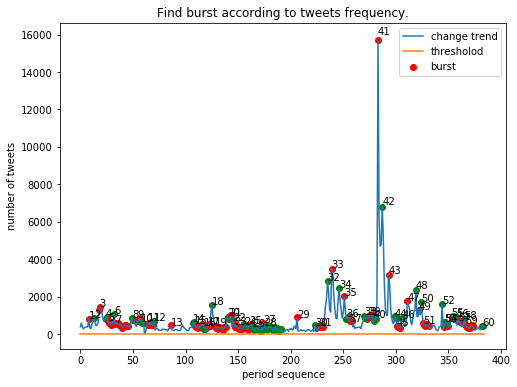

In [5]:
n_burst = 60
threshold = 0
ind_burst, list_word = find_burst(frequency, accumulated_num,terms_stop, threshold, n_burst)
figsize = (8,6)
%matplotlib inline
plot_burst(ind_burst, figsize, frequency, threshold)

In [7]:
gamma = 0.45
numClique = 12
num_words = 150
ignore = 'iphone'
list_date, list_whole, list_clique = find_event(keyword, ignore, ind_burst, list_word, accumulated_num, terms_stop, whole_tweets, dates)

In [8]:
len(list_date)

31

In [9]:
for i in list_clique:
    print i

[u'apple', u'wireless', u'ios', u'charging', u'cash', u'pay', u'faster', u'fix', u'releases', u'update']
[u'apple', u'older', u'cpu', u'explains', u'throttles', u'comes', u'quietly', u'iphones']
[u'apple', u'camera', u'better', u'android', u'user', u'dual', u'massive']
[u'apple', u'wireless', u'earphones', u'week', u'lost', u'pods', u'bought', u'literally', u'jongin', u'unlocked', u'free', u'sim']
[u'apple', u'old', u'replace', u'march', u'short', u'supplies', u'verge', u'phones', u'unlocking']
[u'apple', u'wireless', u'charging', u'support', u'latest', u'signs', u'ubiquitous', u'computing', u'broken', u'though', u'fan']
[u'apple', u'camera', u'app', u'dear', u'great', u'battery', u'settings']
[u'apple', u'camera', u'flickr', u'top', u'brand', u'review', u'dominates', u'largest', u'supplier', u'devices', u'models']
[u'apple', u'older', u'slowed', u'news', u'life', u'broke', u'intentionally', u'models', u'save', u'first', u'uproar', u'iphones']
[u'apple', u'screen', u'cold', u'ios', u'w

In [10]:
df_p = pd.DataFrame({'Date': list_date, 'Clique Words': list_clique, 'Tweets':list_whole})
df_p = df_p.sort_values('Date')
df_p
df_p.to_excel(str(keyword)+'new.xlsx', sheet_name='sheet1', index=False)

In [ ]:
%pylab inline

comatrix.eliminate_zeros()
G = nx.from_scipy_sparse_matrix(comatrix)
G.remove_nodes_from(nx.isolates(G))
dict_label = {i:list_node[i] for i in G.nodes()}

weight_ = nx.get_edge_attributes(G,'weight')
plt.figure(1,figsize=(8,6)) 
#nx.draw(G,labels= dict_label, with_labels = True, edge_labels=weight_)
pos=nx.spring_layout(G,k=4)

#nx.draw(G, pos, labels= dict_label, with_labels = True)

#nx.draw_networkx_edge_labels(G, pos, edge_labels=weight_)

In [23]:
burst_i = 62
list_node = list_word[burst_i].most_common(num_words)
list_node = dict(list_node).keys()
count_matrix, comatrix = build_graph(len(list_node), list_node, burst_i, ind_burst, accumulated_num, terms_stop, 0)
df = pd.DataFrame(data = comatrix.todense(), columns = list_node, index = list_node)
G = df.values
#find the root word
for i in range(len(list(df.columns))):
    if list(df.columns)[i] == keyword.lower():
        break
list_i = findQuasiClique(G, i, gamma, numClique)
clique_word = []
for i in list_i: 
    clique_word.append(list(df.columns)[i])

count, whole, date = find_original(burst_i, ind_burst, clique_word, whole_tweets, dates, accumulated_num, terms_stop)


In [24]:
whole

u'RT @ow: Apple quietly throttles your iPhone CPU as the battery gets older.\n\nExplains why when a new iPhone comes out it _seems_ like your o\u2026'

-------------------------

In [10]:
def find_event(keyword, ignore, ind_burst, list_word, accumulated_num, terms_stop, whole_tweets, dates, num_words= 150, thre = 0, gamma = 0.45, numClique = 12, minClique = 6):
    list_date = []
    list_whole = []
    list_clique = []
    for burst_i in range(len(ind_burst)):
        list_node = list_word[burst_i].most_common(num_words)
        list_node = dict(list_node).keys()
        count_matrix, comatrix = build_graph(len(list_node), list_node, burst_i, ind_burst, accumulated_num, terms_stop, thre)
        df = pd.DataFrame(data = comatrix.todense(), columns = list_node, index = list_node)
        if ignore in list_node:
            df = df.drop([ignore]).drop(ignore,axis = 1)
        G = df.values
        #find the root word
        for i in range(len(list(df.columns))):
            if list(df.columns)[i] == keyword.lower():
                break
        list_i = findQuasiClique(G, i, gamma, numClique)
        clique_word = []
        for i in list_i: 
            clique_word.append(list(df.columns)[i])
        if len(clique_word) > minClique:
            if not isOverlop(list_clique, clique_word):
                count, whole, date = find_original(burst_i, ind_burst, clique_word, whole_tweets, dates, accumulated_num, terms_stop)
                if count < 4:
                    continue
                list_date.append(date)
                list_whole.append(whole)
                list_clique.append(clique_word)
    return list_date, list_whole, list_clique

def isOverlop(list_clique, clique_word):
    
    for clique in list_clique:
        overlap = 0
        for word in clique_word:
            if word in clique:
                overlap +=1
        if overlap > 0.6 * len(clique_word):
            return True
    
    return False
